<center>
  <h2>Trabajo Laboratorio de Implementación III - MCD Virtual Cohorte 2022</h2>
  <h3>Forecasting para una Empresa de Consumo Masivo</h3>
  <h4>Experimento 16 AutoGluon</h4>
</center>

In [1]:
# !pip install autogluon
# !pip install tslearn
# !pip install kmodes
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
from tslearn.utils import to_time_series_dataset
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
import os
from sklearn.preprocessing import OneHotEncoder
from kmodes.kmodes import KModes
from sklearn.metrics import silhouette_score

### Lectura de datos

In [2]:
df_ventas_product = pd.read_csv("C:/Users/usuario/otros/Desktop/MCD/6 Labo III/Forecasting Problem/Datasets/df_ventas_product_fill_extreme_values_095.csv", header = None)
df_ventas_product.columns = ["periodo", "product_id", "tn"]
df_ventas_product.head(5)

,periodo,product_id,tn
0,2017-01-01,20001,934.77222
1,2017-02-01,20001,798.01620
2,2017-03-01,20001,1303.35771
3,2017-04-01,20001,1069.96130
4,2017-05-01,20001,1502.20132


In [3]:
df_product = pd.read_csv("C:/Users/usuario/otros/Desktop/MCD/6 Labo III/Forecasting Problem/Datasets/df_products.csv", header = None)
df_product.columns = ["product_id", "cat1", "cat2", "cat3", "brand", "sku_size"]
df_product["sku_size"] = df_product["sku_size"].astype(str)
df_product.head(5)

,product_id,cat1,cat2,cat3,brand,sku_size
0,20280,HC,ROPA LAVADO,Liquido,LIMPIEX,900
1,20180,HC,ROPA LAVADO,Liquido,LIMPIEX,450
2,20332,HC,ROPA LAVADO,Liquido,LIMPIEX,120
3,20222,HC,ROPA LAVADO,Liquido,LIMPIEX,450
4,20288,HC,ROPA LAVADO,Liquido,LIMPIEX,900


### Clusters de SERIES DE TIEMPO

- Preprocesamiento para armado clusters

In [4]:
df_pivot = df_ventas_product.pivot(index='periodo',
                                   columns='product_id',
                                   values='tn')

print(df_pivot.shape, df_pivot.columns)
df_pivot.head(1)

(36, 780) Index([20001, 20002, 20003, 20004, 20005, 20006, 20007, 20008, 20009, 20010,
       ...
       21248, 21252, 21256, 21259, 21262, 21263, 21265, 21266, 21267, 21276],
      dtype='int64', name='product_id', length=780)


product_id,20001,20002,20003,20004,20005,20006,20007,20008,20009,20010,...,21248,21252,21256,21259,21262,21263,21265,21266,21267,21276
periodo,,,,,,,,,,,,,,,,,,,,,
2017-01-01,934.77222,550.15707,1063.45835,555.91614,494.27011,528.40996,464.67137,523.04609,378.08172,441.25546,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# resample time series data and fill missing values with 0s
df_pivot.index = pd.DatetimeIndex(df_pivot.index)
df_pivot = df_pivot.resample('MS').sum().fillna(0)
print(df_pivot.shape, df_pivot.columns)
df_pivot.head(1)

(36, 780) Index([20001, 20002, 20003, 20004, 20005, 20006, 20007, 20008, 20009, 20010,
       ...
       21248, 21252, 21256, 21259, 21262, 21263, 21265, 21266, 21267, 21276],
      dtype='int64', name='product_id', length=780)


product_id,20001,20002,20003,20004,20005,20006,20007,20008,20009,20010,...,21248,21252,21256,21259,21262,21263,21265,21266,21267,21276
periodo,,,,,,,,,,,,,,,,,,,,,
2017-01-01,934.77222,550.15707,1063.45835,555.91614,494.27011,528.40996,464.67137,523.04609,378.08172,441.25546,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
# transpose data to match format neeed for further processing
df_pivoted = df_pivot.T
df_pivoted = df_pivoted.reset_index()
print(df_pivoted.shape, df_pivoted.columns)
df_pivoted.set_index('product_id', inplace=True)
df_pivoted.head(1)

(780, 37) Index([       'product_id', 2017-01-01 00:00:00, 2017-02-01 00:00:00,
       2017-03-01 00:00:00, 2017-04-01 00:00:00, 2017-05-01 00:00:00,
       2017-06-01 00:00:00, 2017-07-01 00:00:00, 2017-08-01 00:00:00,
       2017-09-01 00:00:00, 2017-10-01 00:00:00, 2017-11-01 00:00:00,
       2017-12-01 00:00:00, 2018-01-01 00:00:00, 2018-02-01 00:00:00,
       2018-03-01 00:00:00, 2018-04-01 00:00:00, 2018-05-01 00:00:00,
       2018-06-01 00:00:00, 2018-07-01 00:00:00, 2018-08-01 00:00:00,
       2018-09-01 00:00:00, 2018-10-01 00:00:00, 2018-11-01 00:00:00,
       2018-12-01 00:00:00, 2019-01-01 00:00:00, 2019-02-01 00:00:00,
       2019-03-01 00:00:00, 2019-04-01 00:00:00, 2019-05-01 00:00:00,
       2019-06-01 00:00:00, 2019-07-01 00:00:00, 2019-08-01 00:00:00,
       2019-09-01 00:00:00, 2019-10-01 00:00:00, 2019-11-01 00:00:00,
       2019-12-01 00:00:00],
      dtype='object', name='periodo')


periodo,2017-01-01,2017-02-01,2017-03-01,2017-04-01,2017-05-01,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,...,2019-03-01,2019-04-01,2019-05-01,2019-06-01,2019-07-01,2019-08-01,2019-09-01,2019-10-01,2019-11-01,2019-12-01
product_id,,,,,,,,,,,,,,,,,,,,,
20001,934.77222,798.0162,1303.35771,1069.9613,1502.20132,1520.06539,1030.67391,1267.39462,1316.94604,1439.75563,...,1470.65653,1647.63848,1629.78233,1109.93769,1678.99318,1261.34529,1660.00561,1561.50552,1397.37231,1504.68856


In [7]:
%%time
# convert dataframe to time_series_dataset
X = to_time_series_dataset(df_pivoted.values)
# normalize time series to zero mean and unit variance
X_train = TimeSeriesScalerMeanVariance().fit_transform(X)
print(X.shape, X_train.shape)

(780, 36, 1) (780, 36, 1)
CPU times: total: 266 ms
Wall time: 307 ms


In [8]:
# create required directory structure
dir_paths = ['./tsl_LABO', './tsl_LABO/models', './tsl_LABO/plots']
for dir_path in dir_paths:
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

In [9]:
%%time
# algorithm configuration
algo = "DTW_kmeans"
metric = "dtw"
# cluster configuration
N_CLUSTERS = 10

model= TimeSeriesKMeans(n_clusters=N_CLUSTERS,
                        metric=metric,
                        n_jobs=-1,
                        random_state=0)
y_pred = model.fit_predict(X_train)
model.to_pickle(f"./tsl_LABO/models/{algo}.pkl")

CPU times: total: 1min 49s
Wall time: 1min 38s


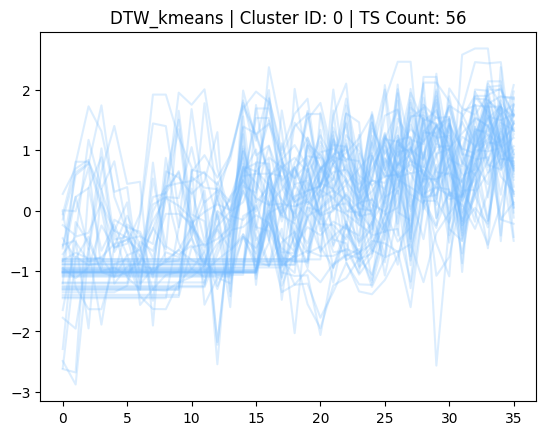

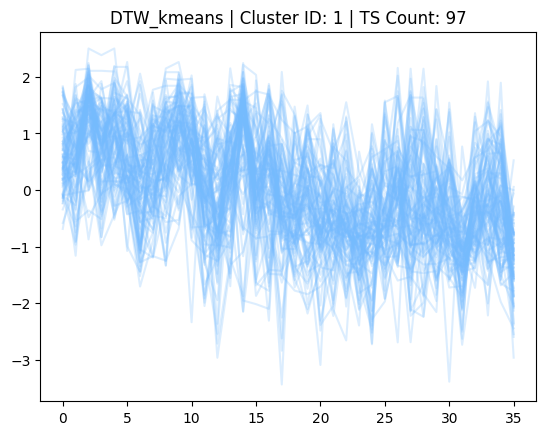

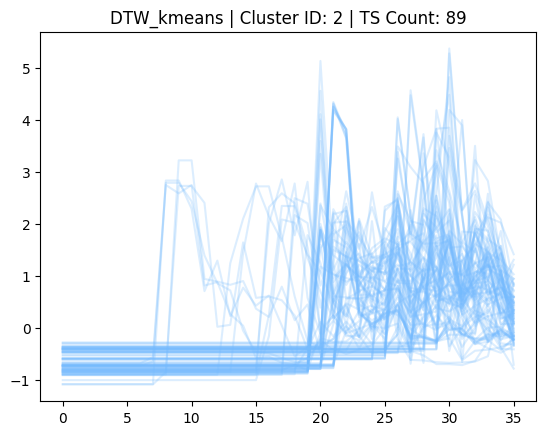

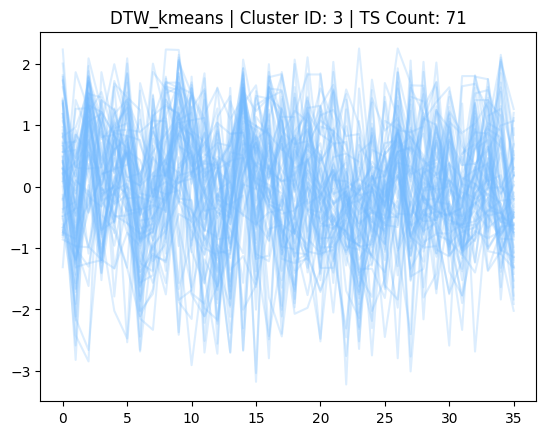

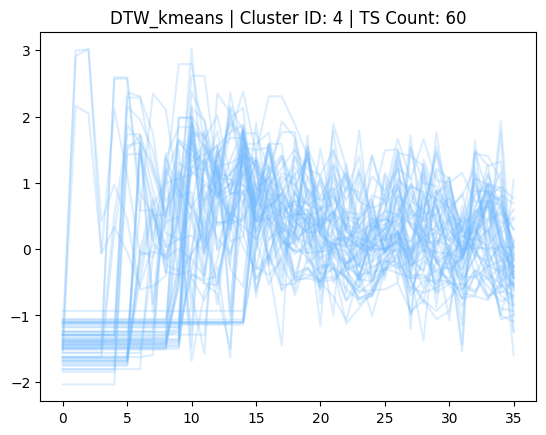

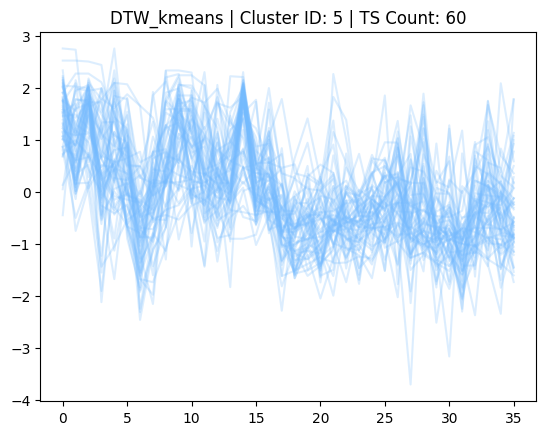

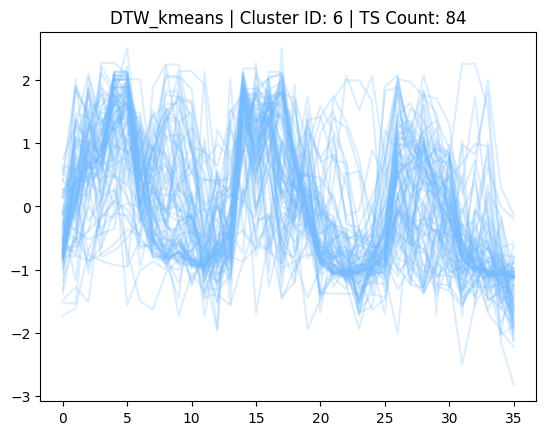

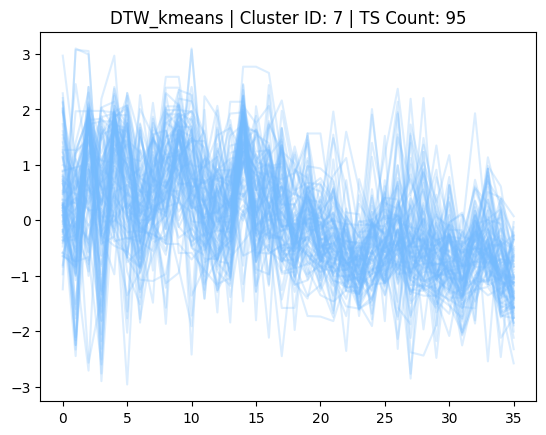

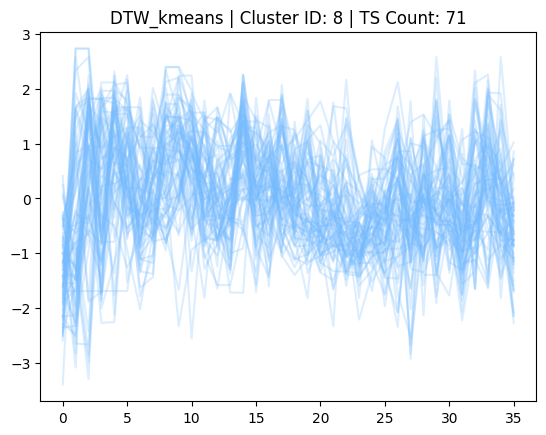

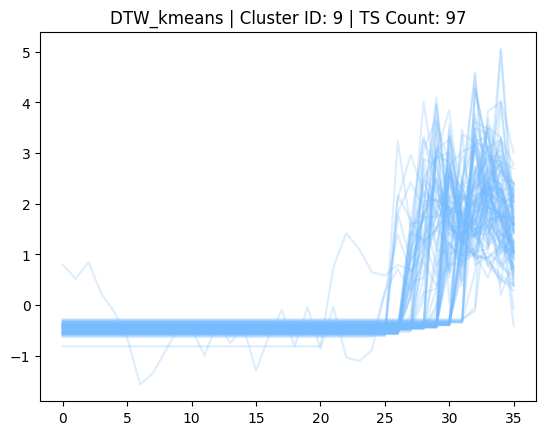

CPU times: total: 3.47 s
Wall time: 3.57 s


In [10]:
%%time

for yi in range(N_CLUSTERS):
    X_sub = X_train[y_pred == yi]
    ts_cnt = pd.Series(y_pred[y_pred == yi]).shape[0]
    fig = plt.figure()
    plt.title(f"{algo} | Cluster ID: {yi} | TS Count: {ts_cnt}")
    for xx in X_sub:
        plt.plot(xx.ravel(), color='xkcd:sky blue', alpha=0.25)
    # fig.savefig(f"./tsl_LABO/plots/{algo}_cls_lbl_{yi}.png", dpi=150)
    plt.show()
    plt.close()

In [11]:
len(df_pivoted)

780

In [12]:
len(y_pred)

780

In [13]:
df_pivoted_extended = pd.concat([df_pivoted.reset_index(), pd.DataFrame(y_pred, columns = ["cluster_id"])], axis = 1)
df_pivoted_extended

,product_id,2017-01-01 00:00:00,2017-02-01 00:00:00,2017-03-01 00:00:00,2017-04-01 00:00:00,2017-05-01 00:00:00,2017-06-01 00:00:00,2017-07-01 00:00:00,2017-08-01 00:00:00,2017-09-01 00:00:00,...,2019-04-01 00:00:00,2019-05-01 00:00:00,2019-06-01 00:00:00,2019-07-01 00:00:00,2019-08-01 00:00:00,2019-09-01 00:00:00,2019-10-01 00:00:00,2019-11-01 00:00:00,2019-12-01 00:00:00,cluster_id
0,20001,934.77222,798.01620,1303.35771,1069.96130,1502.20132,1520.06539,1030.67391,1267.394620,1316.946040,...,1647.638480,1629.782330,1109.93769,1678.99318,1261.34529,1660.00561,1561.505520,1397.37231,1504.68856,8
1,20002,550.15707,505.88633,834.73521,522.35365,843.43785,968.15756,845.39319,619.710780,1065.345290,...,1287.623460,1034.989270,928.36431,1066.44999,813.78215,1090.18771,1509.385713,1423.57739,1087.30855,0
2,20003,1063.45835,752.11520,917.16548,525.82591,620.48202,744.08829,785.12398,864.219280,1436.136245,...,565.337740,590.125150,662.38654,715.20314,635.59563,967.77116,1081.366450,948.29393,892.50129,5
3,20004,555.91614,508.20044,489.91328,512.05402,543.36670,590.50779,569.88117,1042.529790,1113.433648,...,466.709010,603.310810,667.19411,521.71519,482.13372,786.17140,1064.696330,723.94206,637.90002,6
4,20005,494.27011,551.43060,563.89955,662.59032,515.58711,528.58883,625.84925,1014.591725,1014.591725,...,624.998800,897.262970,876.39696,745.74978,536.66800,879.52808,996.782750,606.91173,593.24443,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
775,21263,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.000000,0.000000,...,0.018350,0.022580,0.00988,0.03387,0.03388,0.01128,0.015520,0.03247,0.01270,2
776,21265,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.000000,0.000000,...,0.279585,0.176350,0.05121,0.02959,0.01593,0.01707,0.109210,0.06600,0.05007,2
777,21266,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.000000,0.000000,...,0.278332,0.176340,0.05235,0.05916,0.01480,0.02844,0.118310,0.06713,0.05121,2
778,21267,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.000000,0.000000,...,0.122910,0.231581,0.05882,0.07452,0.04054,0.01830,0.096760,0.04052,0.01569,2


In [14]:
df_tts = pd.melt(df_pivoted_extended, id_vars=['product_id', 'cluster_id'])
df_tts.columns = ['product_id', 'cluster_id', 'periodo', 'tn']
df_tts = df_tts[['periodo', 'product_id', 'cluster_id', 'tn']]
df_tts

,periodo,product_id,cluster_id,tn
0,2017-01-01 00:00:00,20001,8,934.77222
1,2017-01-01 00:00:00,20002,0,550.15707
2,2017-01-01 00:00:00,20003,5,1063.45835
3,2017-01-01 00:00:00,20004,6,555.91614
4,2017-01-01 00:00:00,20005,0,494.27011
...,...,...,...,...
28075,2019-12-01 00:00:00,21263,2,0.01270
28076,2019-12-01 00:00:00,21265,2,0.05007
28077,2019-12-01 00:00:00,21266,2,0.05121
28078,2019-12-01 00:00:00,21267,2,0.01569


In [15]:
len(df_tts[df_tts.tn != 0]) == len(df_ventas_product)
# df_tts tiene más registros porque las fechas sin tn por serie fueron completados con 0

True

In [16]:
df_tts.tn.sum()

1110207.065571

In [17]:
df_ventas_product.tn.sum()

1110207.065571

In [18]:
clusters_series = df_tts[["product_id", "cluster_id"]].drop_duplicates()
clusters_series

,product_id,cluster_id
0,20001,8
1,20002,0
2,20003,5
3,20004,6
4,20005,0
...,...,...
775,21263,2
776,21265,2
777,21266,2
778,21267,2


In [19]:
clusters_series.cluster_id.value_counts()

cluster_id
1    97
9    97
7    95
2    89
6    84
8    71
3    71
5    60
4    60
0    56
Name: count, dtype: int64

### Cluster general de PRODUCTOS, agregando clusters de SERIES

In [20]:
df_product_cluster = pd.merge(df_product, clusters_series, how = "inner", on = "product_id")
df_product_cluster["cluster_id"] = df_product_cluster["cluster_id"].astype(str)
df_product_cluster.dtypes

product_id     int64
cat1          object
cat2          object
cat3          object
brand         object
sku_size      object
cluster_id    object
dtype: object

In [21]:
df_product_cluster.head(5)

,product_id,cat1,cat2,cat3,brand,sku_size,cluster_id
0,20280,HC,ROPA LAVADO,Liquido,LIMPIEX,900,3
1,20180,HC,ROPA LAVADO,Liquido,LIMPIEX,450,3
2,20332,HC,ROPA LAVADO,Liquido,LIMPIEX,120,3
3,20222,HC,ROPA LAVADO,Liquido,LIMPIEX,450,1
4,20288,HC,ROPA LAVADO,Liquido,LIMPIEX,900,5


In [22]:
# Seleccionar las características categóricas
categorical_features = ['cat1', 'cat2', 'cat3', 'brand', 'sku_size', 'cluster_id']
# Aplicar One-Hot Encoding
encoder = OneHotEncoder()
encoded_features = encoder.fit_transform(df_product_cluster[categorical_features])
# Convertir a DataFrame
encoded_df = pd.DataFrame(encoded_features.toarray(), columns=encoder.get_feature_names_out(categorical_features))
# Añadir de nuevo el product_id para referencia
encoded_df['product_id'] = df_product_cluster['product_id'].values
encoded_df.head(5)

,cat1_FOODS,cat1_HC,cat1_PC,cat1_REF,cat2_ADEREZOS,cat2_CABELLO,cat2_DENTAL,cat2_DEOS,cat2_HOGAR,cat2_OTROS,...,cluster_id_1,cluster_id_2,cluster_id_3,cluster_id_4,cluster_id_5,cluster_id_6,cluster_id_7,cluster_id_8,cluster_id_9,product_id
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,20280
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,20180
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,20332
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20222
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,20288


In [23]:
# Ajustar el modelo con el número óptimo de clusters 
n_clusters_optimo = 10

km_optimo = KModes(n_clusters=n_clusters_optimo, init='Huang', n_init=5, verbose=1)
clusters_optimos = km_optimo.fit_predict(encoded_df.drop('product_id', axis=1))

# Añadir los clusters óptimos al DataFrame original
df_product_cluster['cluster'] = clusters_optimos

# Ver el DataFrame con los clusters óptimos
df_product_cluster.head()

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 294, cost: 3172.0
Run 1, iteration: 2/100, moves: 108, cost: 3078.0
Run 1, iteration: 3/100, moves: 0, cost: 3078.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 268, cost: 3233.0
Run 2, iteration: 2/100, moves: 85, cost: 3158.0
Run 2, iteration: 3/100, moves: 16, cost: 3148.0
Run 2, iteration: 4/100, moves: 7, cost: 3148.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 216, cost: 3064.0
Run 3, iteration: 2/100, moves: 85, cost: 3049.0
Run 3, iteration: 3/100, moves: 13, cost: 3049.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 330, cost: 3160.0
Run 4, iteration: 2/100, moves: 58, cost: 3122.0
Run 4, iteration: 3/100, moves: 5, cost: 3122.0
Init: initializing centroids
Init: initia

,product_id,cat1,cat2,cat3,brand,sku_size,cluster_id,cluster
0,20280,HC,ROPA LAVADO,Liquido,LIMPIEX,900,3,3
1,20180,HC,ROPA LAVADO,Liquido,LIMPIEX,450,3,3
2,20332,HC,ROPA LAVADO,Liquido,LIMPIEX,120,3,3
3,20222,HC,ROPA LAVADO,Liquido,LIMPIEX,450,1,3
4,20288,HC,ROPA LAVADO,Liquido,LIMPIEX,900,5,3


In [24]:
df_product_cluster = df_product_cluster[["product_id", "cluster"]]
df_product_cluster.groupby(["cluster"])["product_id"].nunique()

cluster
0    199
1     90
2     46
3    104
4     83
5     98
6     77
7     27
8     39
9     17
Name: product_id, dtype: int64

### Modelado

In [25]:
df = pd.merge(df_ventas_product, df_product_cluster, how = "left", on = "product_id")
df

,periodo,product_id,tn,cluster
0,2017-01-01,20001,934.772220,3
1,2017-02-01,20001,798.016200,3
2,2017-03-01,20001,1303.357710,3
3,2017-04-01,20001,1069.961300,3
4,2017-05-01,20001,1502.201320,3
...,...,...,...,...
22344,2019-12-01,21087,1.022050,6
22345,2019-09-01,21214,0.342500,0
22346,2019-10-01,21214,0.217350,0
22347,2019-11-01,21214,0.765477,0


In [26]:
N_CLUSTERS = n_clusters_optimo

# Crear un bucle for que itere sobre cada cluster_id
for cluster_id in range(N_CLUSTERS):
    # Filtrar el dataframe original df_tts por el cluster_id actual
    df_cluster = df[df.cluster == cluster_id]
    # Eliminar la columna "cluster_id" del dataframe filtrado
    df_cluster = df_cluster.drop(columns={"cluster"})
    # Imprimir información sobre el cluster actual
    print(f"---------------C{cluster_id}---------------")
    print(df_cluster.periodo.min(), df_cluster.periodo.max())
    print(len(df_cluster.drop_duplicates(subset="product_id")))
    # Asignar el dataframe resultante a una variable específica para cada cluster (opcional)
    globals()[f"df_ventas_product_cluster{cluster_id}"] = df_cluster

---------------C0---------------
2017-01-01 2019-12-01
199
---------------C1---------------
2017-01-01 2019-12-01
90
---------------C2---------------
2017-01-01 2019-12-01
46
---------------C3---------------
2017-01-01 2019-12-01
104
---------------C4---------------
2017-01-01 2019-12-01
83
---------------C5---------------
2017-01-01 2019-12-01
98
---------------C6---------------
2017-01-01 2019-12-01
77
---------------C7---------------
2017-01-01 2019-12-01
27
---------------C8---------------
2017-01-01 2019-12-01
39
---------------C9---------------
2017-01-01 2019-12-01
17


In [27]:
total_productos_unicos = 0

# Crear un bucle for que itere sobre cada cluster_id
for cluster_id in range(N_CLUSTERS):
    # Obtener el nombre de la variable del dataframe del cluster actual
    df_name = f"df_ventas_product_cluster{cluster_id}"
    
    # Verificar si la variable existe en el entorno global
    if df_name in globals():
        # Obtener el dataframe del cluster actual
        df_cluster = globals()[df_name]
        
        # Calcular la cantidad de productos únicos en el cluster actual
        productos_unicos = len(df_cluster.drop_duplicates(subset="product_id"))
        
        # Sumar al total de productos únicos
        total_productos_unicos += productos_unicos

# Imprimir el total de productos únicos en todos los clusters
print("Total de productos únicos en todos los clusters:", total_productos_unicos)

Total de productos únicos en todos los clusters: 780


In [28]:
# Crear un bucle for que itere sobre cada cluster_id
for cluster_id in range(N_CLUSTERS):
    # Construir el nombre de la variable del dataframe del cluster actual
    df_name = f"df_ventas_product_cluster{cluster_id}"
    
    # Verificar si la variable existe en el entorno global
    if df_name in globals():
        # Obtener el dataframe del cluster actual
        df_cluster = globals()[df_name]
        
        # Renombrar las columnas especificadas en el dataframe del cluster actual
        df_cluster = df_cluster.rename(columns={"periodo": "timestamp", "product_id": "item_id", "tn": "target"})
        
        # Asignar el dataframe renombrado de vuelta a la variable global
        globals()[df_name] = df_cluster

In [29]:
df_ventas_product_cluster0.head(1)

,timestamp,item_id,target
1836,2017-01-01,20058,159.93297


In [30]:
df_ventas_product_cluster9.head(1)

,timestamp,item_id,target
1404,2017-01-01,20044,194.83483


In [31]:
# Lista para almacenar los objetos TimeSeriesDataFrame
time_series_dataframes = []

# Crear un bucle for que itere sobre cada cluster_id
for cluster_id in range(N_CLUSTERS):
    # Construir el nombre de la variable del dataframe del cluster actual
    df_name = f"df_ventas_product_cluster{cluster_id}"
    
    # Verificar si la variable existe en el entorno actual (recomendado usar locals())
    if df_name in locals():
        # Obtener el dataframe del cluster actual
        df_cluster = locals()[df_name]
        # Crear un objeto TimeSeriesDataFrame con el dataframe actual
        data = TimeSeriesDataFrame(df_cluster)
        # Agregar el objeto TimeSeriesDataFrame a la lista
        time_series_dataframes.append(data)
        # Opcional: Asignar el objeto a una variable individual si es necesario
        globals()[f"data{cluster_id}"] = data

In [32]:
print("PREDICTOR 0")
predictor_0 = TimeSeriesPredictor(target='target', prediction_length=2, freq="M").fit(data0)
print("PREDICTOR 1")
predictor_1 = TimeSeriesPredictor(target='target', prediction_length=2, freq="M").fit(data1)
print("PREDICTOR 2")
predictor_2 = TimeSeriesPredictor(target='target', prediction_length=2, freq="M").fit(data2)
print("PREDICTOR 3")
predictor_3= TimeSeriesPredictor(target='target', prediction_length=2, freq="M").fit(data3)
print("PREDICTOR 4")
predictor_4= TimeSeriesPredictor(target='target', prediction_length=2, freq="M").fit(data4)
print("PREDICTOR 5")
predictor_5= TimeSeriesPredictor(target='target', prediction_length=2, freq="M").fit(data5)
print("PREDICTOR 6")
predictor_6= TimeSeriesPredictor(target='target', prediction_length=2, freq="M").fit(data6)
print("PREDICTOR 7")
predictor_7= TimeSeriesPredictor(target='target', prediction_length=2, freq="M").fit(data7)
print("PREDICTOR 8")
predictor_8= TimeSeriesPredictor(target='target', prediction_length=2, freq="M").fit(data8)
print("PREDICTOR 9")
predictor_9= TimeSeriesPredictor(target='target', prediction_length=2, freq="M").fit(data9)

PREDICTOR 0

Frequency 'M' stored as 'ME'
Beginning AutoGluon training...
AutoGluon will save models to 'AutogluonModels\ag-20240707_150814'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.11.2
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
CPU Count:          8
GPU Count:          0
Memory Avail:       2.13 GB / 7.88 GB (27.0%)
Disk Space Avail:   4.00 GB / 110.21 GB (3.6%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'ME',
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 2,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'target',
 'verbosity': 2}

train_data with frequency 'None' has been resa

Provided train_data has 5258 rows (NaN fraction=0.2%), 199 time series. Median time series length is 36 (min=4, max=36). 
	Removing 18 short time series from train_data. Only series with length >= 7 will be used for training.
	After filtering, train_data has 5165 rows (NaN fraction=0.2%), 181 time series. Median time series length is 36 (min=7, max=36). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2024-07-07 12:08:16
Models that will be trained: ['SeasonalNaive', 'RecursiveTabular', 'DirectTabular', 'CrostonSBA', 'NPTS', 'DynamicOptimizedTheta', 'AutoETS', 'AutoARIMA', 'Chronos[base]', 'TemporalFusionTransformer', 'DeepAR', 'PatchTST']
Training timeseries model SeasonalNaive. 
	-0.2330       = Validation score (-WQL)
	0.02 

PREDICTOR 1


Provided train_data has 3074 rows (NaN fraction=0.1%), 90 time series. Median time series length is 36 (min=8, max=36). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2024-07-07 12:18:50
Models that will be trained: ['SeasonalNaive', 'RecursiveTabular', 'DirectTabular', 'CrostonSBA', 'NPTS', 'DynamicOptimizedTheta', 'AutoETS', 'AutoARIMA', 'Chronos[base]', 'TemporalFusionTransformer', 'DeepAR', 'PatchTST']
Training timeseries model SeasonalNaive. 
	-0.4312       = Validation score (-WQL)
	0.02    s     = Training runtime
	6.05    s     = Validation (prediction) runtime
Training timeseries model RecursiveTabular. 
	Time series in the dataset are too short for chosen differences [12]. Setting differences to [1].
	-0.3904       

PREDICTOR 2


train_data with frequency 'MS' has been resampled to frequency 'ME'.
Provided train_data has 1418 rows, 46 time series. Median time series length is 36 (min=5, max=36). 
	Removing 4 short time series from train_data. Only series with length >= 7 will be used for training.
	After filtering, train_data has 1397 rows, 42 time series. Median time series length is 36 (min=14, max=36). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2024-07-07 12:31:23
Models that will be trained: ['SeasonalNaive', 'RecursiveTabular', 'DirectTabular', 'CrostonSBA', 'NPTS', 'DynamicOptimizedTheta', 'AutoETS', 'AutoARIMA', 'Chronos[base]', 'TemporalFusionTransformer', 'DeepAR', 'PatchTST']
Training timeseries model SeasonalNaive. 
	-0.2141       = Val

PREDICTOR 3


train_data with frequency 'None' has been resampled to frequency 'ME'.
Provided train_data has 3147 rows (NaN fraction=0.1%), 104 time series. Median time series length is 36 (min=4, max=36). 
	Removing 4 short time series from train_data. Only series with length >= 7 will be used for training.
	After filtering, train_data has 3127 rows (NaN fraction=0.1%), 100 time series. Median time series length is 36 (min=7, max=36). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2024-07-07 12:43:21
Models that will be trained: ['SeasonalNaive', 'RecursiveTabular', 'DirectTabular', 'CrostonSBA', 'NPTS', 'DynamicOptimizedTheta', 'AutoETS', 'AutoARIMA', 'Chronos[base]', 'TemporalFusionTransformer', 'DeepAR', 'PatchTST']
Training timeseries

PREDICTOR 4


train_data with frequency 'None' has been resampled to frequency 'ME'.
Provided train_data has 2389 rows (NaN fraction=0.1%), 83 time series. Median time series length is 36 (min=6, max=36). 
	Removing 3 short time series from train_data. Only series with length >= 7 will be used for training.
	After filtering, train_data has 2371 rows (NaN fraction=0.1%), 80 time series. Median time series length is 36 (min=8, max=36). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2024-07-07 12:58:05
Models that will be trained: ['SeasonalNaive', 'RecursiveTabular', 'DirectTabular', 'CrostonSBA', 'NPTS', 'DynamicOptimizedTheta', 'AutoETS', 'AutoARIMA', 'Chronos[base]', 'TemporalFusionTransformer', 'DeepAR', 'PatchTST']
Training timeseries m

PREDICTOR 5


Provided train_data has 2778 rows (NaN fraction=0.1%), 98 time series. Median time series length is 36 (min=6, max=36). 
	Removing 1 short time series from train_data. Only series with length >= 7 will be used for training.
	After filtering, train_data has 2772 rows (NaN fraction=0.1%), 97 time series. Median time series length is 36 (min=7, max=36). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2024-07-07 13:10:56
Models that will be trained: ['SeasonalNaive', 'RecursiveTabular', 'DirectTabular', 'CrostonSBA', 'NPTS', 'DynamicOptimizedTheta', 'AutoETS', 'AutoARIMA', 'Chronos[base]', 'TemporalFusionTransformer', 'DeepAR', 'PatchTST']
Training timeseries model SeasonalNaive. 
	-0.3044       = Validation score (-WQL)
	0.03    

PREDICTOR 6


Provided train_data has 2071 rows (NaN fraction=0.1%), 77 time series. Median time series length is 36 (min=4, max=36). 
	Removing 6 short time series from train_data. Only series with length >= 7 will be used for training.
	After filtering, train_data has 2039 rows (NaN fraction=0.1%), 71 time series. Median time series length is 36 (min=7, max=36). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2024-07-07 13:27:03
Models that will be trained: ['SeasonalNaive', 'RecursiveTabular', 'DirectTabular', 'CrostonSBA', 'NPTS', 'DynamicOptimizedTheta', 'AutoETS', 'AutoARIMA', 'Chronos[base]', 'TemporalFusionTransformer', 'DeepAR', 'PatchTST']
Training timeseries model SeasonalNaive. 
	-0.2883       = Validation score (-WQL)
	0.02    

PREDICTOR 7


Provided train_data has 674 rows, 27 time series. Median time series length is 27 (min=7, max=36). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2024-07-07 13:39:36
Models that will be trained: ['SeasonalNaive', 'RecursiveTabular', 'DirectTabular', 'CrostonSBA', 'NPTS', 'DynamicOptimizedTheta', 'AutoETS', 'AutoARIMA', 'Chronos[base]', 'TemporalFusionTransformer', 'DeepAR', 'PatchTST']
Training timeseries model SeasonalNaive. 
	-0.1890       = Validation score (-WQL)
	0.03    s     = Training runtime
	4.96    s     = Validation (prediction) runtime
Training timeseries model RecursiveTabular. 
	Time series in the dataset are too short for chosen differences [12]. Setting differences to [1].
	-0.2044       = Validation score (-

PREDICTOR 8


Provided train_data has 1080 rows (NaN fraction=0.1%), 39 time series. Median time series length is 36 (min=4, max=36). 
	Removing 8 short time series from train_data. Only series with length >= 7 will be used for training.
	After filtering, train_data has 1037 rows (NaN fraction=0.1%), 31 time series. Median time series length is 36 (min=21, max=36). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2024-07-07 13:47:42
Models that will be trained: ['SeasonalNaive', 'RecursiveTabular', 'DirectTabular', 'CrostonSBA', 'NPTS', 'DynamicOptimizedTheta', 'AutoETS', 'AutoARIMA', 'Chronos[base]', 'TemporalFusionTransformer', 'DeepAR', 'PatchTST']
Training timeseries model SeasonalNaive. 
	-0.3227       = Validation score (-WQL)
	0.04   

PREDICTOR 9


Provided train_data has 486 rows, 17 time series. Median time series length is 36 (min=5, max=36). 
	Removing 2 short time series from train_data. Only series with length >= 7 will be used for training.
	After filtering, train_data has 476 rows, 15 time series. Median time series length is 36 (min=20, max=36). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2024-07-07 13:58:34
Models that will be trained: ['SeasonalNaive', 'RecursiveTabular', 'DirectTabular', 'CrostonSBA', 'NPTS', 'DynamicOptimizedTheta', 'AutoETS', 'AutoARIMA', 'Chronos[base]', 'TemporalFusionTransformer', 'DeepAR', 'PatchTST']
Training timeseries model SeasonalNaive. 
	-0.3007       = Validation score (-WQL)
	0.02    s     = Training runtime
	4.46    s     =

In [33]:
predictions0 = predictor_0.predict(data0)
predictions1 = predictor_1.predict(data1)
predictions2 = predictor_2.predict(data2)
predictions3 = predictor_3.predict(data3)
predictions4 = predictor_4.predict(data4)
predictions5 = predictor_5.predict(data5)
predictions6 = predictor_6.predict(data6)
predictions7 = predictor_7.predict(data7)
predictions8 = predictor_8.predict(data8)
predictions9 = predictor_9.predict(data9)

data with frequency 'None' has been resampled to frequency 'ME'.
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble
data with frequency 'None' has been resampled to frequency 'ME'.
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble
data with frequency 'MS' has been resampled to frequency 'ME'.
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble
data with frequency 'None' has been resampled to frequency 'ME'.
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble
data with frequency 'None' has been resampled to frequency 'ME'.
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble
data with frequency 'None' has been resampled to frequency 'ME'.
Model not specified in predict, will default to the model with the best valid

In [34]:
predictions = pd.concat([predictions0,
                         predictions1,
                         predictions2,
                         predictions3,
                         predictions4,
                         predictions5,
                         predictions6,
                         predictions7,
                         predictions8,
                         predictions9])

In [35]:
predictions_v1 = predictions.copy()
predictions_v1 = predictions_v1.reset_index()
predictions_v1 = predictions_v1[["item_id", "timestamp", "mean"]]
predictions_v1 = predictions_v1[predictions_v1.timestamp == "2020-02-29"]
predictions_v1 = predictions_v1.drop(columns = {"timestamp"})
predictions_v1 = predictions_v1.rename(columns = {"item_id":"product_id", "mean":"tn"})
predictions_v1.head(5)

,product_id,tn
1,20058,121.847306
3,20111,77.869764
5,20120,64.312043
7,20132,56.478278
9,20231,22.364950


In [36]:
len(predictions_v1.product_id.unique())

780

In [37]:
predictions_v1.to_csv("C:/Users/usuario/otros/Desktop\MCD/6 Labo III/Forecasting Problem/Outputs/prediccion_autogluon_10cluster_products_outliers.csv", sep = ",", index = False)